# Регрессия - пора творить!

Если вы дошли до этой практики и выполнили все предыдущие - вау! Аплодисменты вам!

<p align="center"><img src="https://raw.githubusercontent.com/AleksDevEdu/ml_edu/master/assets/leo.png" width=500/></p>



Тем не менее, не время расслабляться! На этот раз, мы не будем рассказывать вам новый материал - лишь дадим пару напутствий и пожелаем успехов и сил!

В этот раз вам предлагается разработать модель предсказания цены домов по набору данных Boston Houses Pricing. Мы его уже немного пощупали в прошлой практике, но в этой вам предстоит сделать всё самостоятельно и на полных данных!

Что надо будет сделать:
- Загрузить данные
- Посмотреть и размер, и примеры данных
- Проверить количество пропусков в данных
    - Убедиться, что пропусков в данных нет и можно строить **baseline**
- Делим данные на train и test 
    - Делаем это один раз! Все дальнейшие модификации и улучшения должны делаться на основе единственного разделения!
    - И не забудьте зафиксировать сид! Переменную `RANDOM_SEED` мы даём ниже
- Создаем baseline модель, снимаем метрики на тестовой выборке
- Производим анализ данных, готовим план по очистке и предобработке данных
- Создаем функцию очистки
- Производим очистку train и test выборок -> обучаем модель с очищенными данными
    - Снимаем метрики и так мы оцениваем влияние очистки данных на обучение
- Создаем класс предобработки данных
- Производим предобработку очищенных данных -> обучаем модель
    - Снимаем метрики и так мы оцениваем влияние предобработки данных на обучение

А дальше можете пофантазировать, почитать интернет и посмотреть, как улучшить метрики! 

**Ваша цель - достигнуть наилучших показателей!**

Вот вам пара идей по интересной организации предобработке:
- По признаку `CRIM` создать признак `is_CRIM`, который будет равен 1, если `CRIM` не равен 0 и 0, если `CRIM` равен нулю
- Сделать обучение модели [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html), посмотреть, какие признаки имеют веса близкие к 0 и убрать их из обучения как незначимые
- Оставить только признаки с высокой корреляцией с целевой переменной
- Посмотреть, какие переменные коррелирцют между собой и оставить только единственные из пар коррелирующих
- Посмотреть, в каких примерах данных модель ошибается сильнее всего (отсортировать записи из теста по величине ошибки) и проанализировать, есть ли какая-то зависимость или шум
- Комбинировать разные подходы в зависимости от того, помогает это предсказаниям или нет

Ещё большим плюсом будет, если вы покажете, как влияет каждый этап предобработки на результаты обучения!

Baseline Mean Squared Error: 21.51744423117727


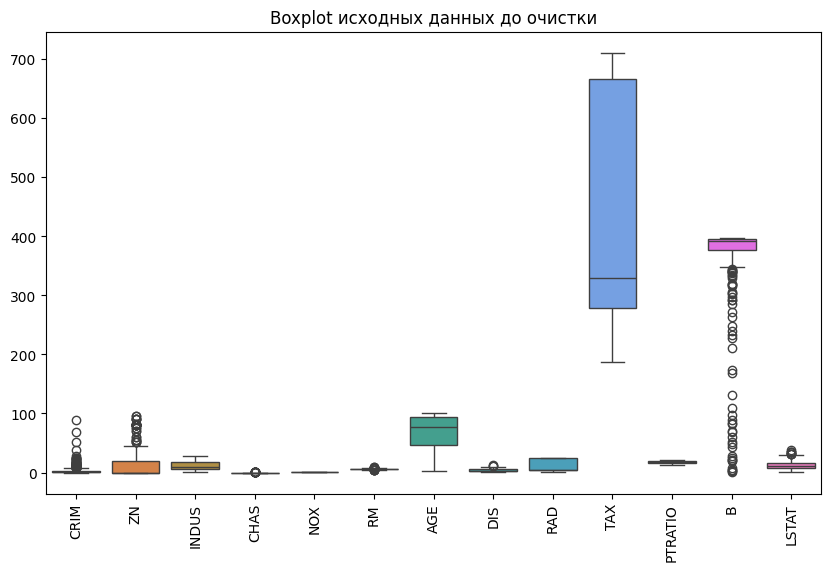

In [21]:
# Зафиксируем состояние случайных чисел
import numpy as np
import pandas as pd
import random
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
#Загрузите данные
df_src = pd.read_csv('boston.csv')
#Посмотреть размер и примеры данных
df_src.shape
df_src.head(8)
#Проверить количество пропусков в данных
df_src.info()
df_src.isnull().sum()
#Делим данные на train и test
df_copy=df_src.copy()
from sklearn.model_selection import train_test_split
X = df_copy.drop(columns=['MEDV'])  # MEDV-столб с ценами на дома
y = df_copy['MEDV']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.3, random_state=RANDOM_SEED, shuffle=True)
# создаём Basiline модель, снимаем метрики на тестовой выборке
#_____________________________________________________________________


# Создайте и обучите базовую модель (линейная регрессия)
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)
# Сделайте предсказания на тестовых данных
predictions = baseline_model.predict(X_test)
# Оцените производительность базовой модели на тестовых данных
baseline_mse = mean_squared_error(y_test, predictions)
print(f"Baseline Mean Squared Error: {baseline_mse}")
#___________________________________________________
#
def clean_data(data):
    imputer = SimpleImputer(strategy='median')  # медиана для пропусков
    data_filled = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)
    scaler = StandardScaler()
    scaled_data = pd.DataFrame(scaler.fit_transform(data_filled), columns=data.columns)

    return scaled_data


# до очистки
plt.figure(figsize=(10, 6))
sns.boxplot(data=X_train)
plt.title('Boxplot исходных данных до очистки')
plt.xticks(rotation=90)
plt.show()

# очищенные 
cleaned_X_train = clean_data(X_train)


def display_data(data1, data2, title1='Before Cleaning', title2='After Cleaning'):
    desc_data1 = data1.describe().T
    desc_data2 = data2.describe().T

    desc_data1 = desc_data1.add_prefix(f"{title1} ")
    desc_data2 = desc_data2.add_prefix(f"{title2} ")

    df_combined = pd.concat([desc_data1, desc_data2], axis=1)
    
    return df_combined

# Показать статистику по исходным и очищенным данным
display_data(X_train, cleaned_X_train, title1='Before Cleaning - Train', title2='After Cleaning - Train')

class DataPreprocessing:
    def __init__(self):
        self.columns_to_scale = None

    def fit(self, df):
        self.columns_to_scale = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

    def transform(self, df):

        if self.columns_to_scale:
            scaler = StandardScaler()
            df[self.columns_to_scale] = scaler.fit_transform(df[self.columns_to_scale])

        imputer = SimpleImputer(strategy='median')
        df[df.select_dtypes(include=['float64', 'int64']).columns] = imputer.fit_transform(df.select_dtypes(include=['float64', 'int64']))

        return df


Что мы ждем от вас? 

Готовый ноутбук с таким же названием, в котором будут обязательные пункты с выводами по анализу данных и анализу поведения модели, а также дополнительные пункты по вашим размышлениям и процессу улучшения модели.

Успехов вам, мы в вас верим и уверены, что вы точно справитесь!

<p align="center"><img src="https://raw.githubusercontent.com/AleksDevEdu/ml_edu/master/assets/cat-computer-peek-out-36960208.jpg" width=600/></p>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import random
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
# Загрузка данных
df = pd.read_csv('boston.csv')

# Разделение данных на признаки и целевую переменную
X = df.drop(columns=['MEDV'])
y = df['MEDV']

# Разделение на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Класс для предобработки данных
class DataPreprocessing:
    def __init__(self):
        self.columns_to_scale = None

    def fit(self, df):
        self.columns_to_scale = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

    def transform(self, df):
        if self.columns_to_scale:
            scaler = StandardScaler()
            df[self.columns_to_scale] = scaler.fit_transform(df[self.columns_to_scale])

        imputer = SimpleImputer(strategy='median')
        df[df.select_dtypes(include=['float64', 'int64']).columns] = imputer.fit_transform(df.select_dtypes(include=['float64', 'int64']))

        return df

# Предобработка данных
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Обучение модели
baseline_model = LinearRegression()
baseline_model.fit(X_train_processed, y_train)

# Оценка модели на тестовых данных
predictions = baseline_model.predict(X_test_processed)
baseline_mse = mean_squared_error(y_test, predictions)
print(f"Baseline Mean Squared Error: {baseline_mse}")

Baseline Mean Squared Error: 24.13479128906756


In [2]:
from sklearn.linear_model import Lasso

class AdvancedDataPreprocessing(DataPreprocessing):
    def __init__(self):
        super().__init__()

    def transform(self, df):
        df = super().transform(df)
        df['is_CRIM'] = df['CRIM'].apply(lambda x: 1 if x != 0 else 0)
        
        return df

advanced_preprocessor = AdvancedDataPreprocessing()
advanced_preprocessor.fit(X_train)
X_train_processed = advanced_preprocessor.transform(X_train)
X_test_processed = advanced_preprocessor.transform(X_test)

additional_preprocessor = DataPreprocessing()
additional_preprocessor.fit(X_train)
X_train_additional_processed = additional_preprocessor.transform(X_train)
X_test_additional_processed = additional_preprocessor.transform(X_test)
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train_additional_processed, y_train)
non_significant_features = X_train_additional_processed.columns[lasso_model.coef_ == 0]
X_train_processed.drop(columns=non_significant_features, inplace=True)
X_test_processed.drop(columns=non_significant_features, inplace=True)


advanced_model = LinearRegression()
advanced_model.fit(X_train_processed, y_train)

advanced_predictions = advanced_model.predict(X_test_processed)
advanced_mse = mean_squared_error(y_test, advanced_predictions)
print(f"Advanced Mean Squared Error: {advanced_mse}")


Advanced Mean Squared Error: 24.03829559269392


In [4]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]}
ridge_model = Ridge()
ridge_grid_search = GridSearchCV(ridge_model, param_grid, cv=5, scoring='neg_mean_squared_error')
ridge_grid_search.fit(X_train_processed, y_train)

print(f"Best Parameters for Ridge: {ridge_grid_search.best_params_}")
print(f"Best MSE for Ridge: {-ridge_grid_search.best_score_}")

Best Parameters for Ridge: {'alpha': 10.0}
Best MSE for Ridge: 25.72680929283019


In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10, 15]
}
random_forest = RandomForestRegressor(random_state=42)
random_forest_grid_search = GridSearchCV(random_forest, param_grid, cv=5, scoring='neg_mean_squared_error')
random_forest_grid_search.fit(X_train_processed, y_train)
print(f"Best Parameters for RandomForestRegressor: {random_forest_grid_search.best_params_}")
print(f"Best MSE for RandomForestRegressor: {-random_forest_grid_search.best_score_}")




Best Parameters for RandomForestRegressor: {'max_depth': None, 'n_estimators': 100}
Best MSE for RandomForestRegressor: 14.679279239436624


In [6]:
from sklearn.ensemble import GradientBoostingRegressor

#кажется тут получились наилучшое значение
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.5]
}

gradient_boost = GradientBoostingRegressor(random_state=42)

gradient_boost_grid_search = GridSearchCV(gradient_boost, param_grid, cv=5, scoring='neg_mean_squared_error')

gradient_boost_grid_search.fit(X_train_processed, y_train)

print(f"Best Parameters for GradientBoostingRegressor: {gradient_boost_grid_search.best_params_}")
print(f"Best MSE for GradientBoostingRegressor: {-gradient_boost_grid_search.best_score_}")


Best Parameters for GradientBoostingRegressor: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150}
Best MSE for GradientBoostingRegressor: 11.97249112950691
